In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import numpy as np
import matplotlib.pyplot as plt
import sage 

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

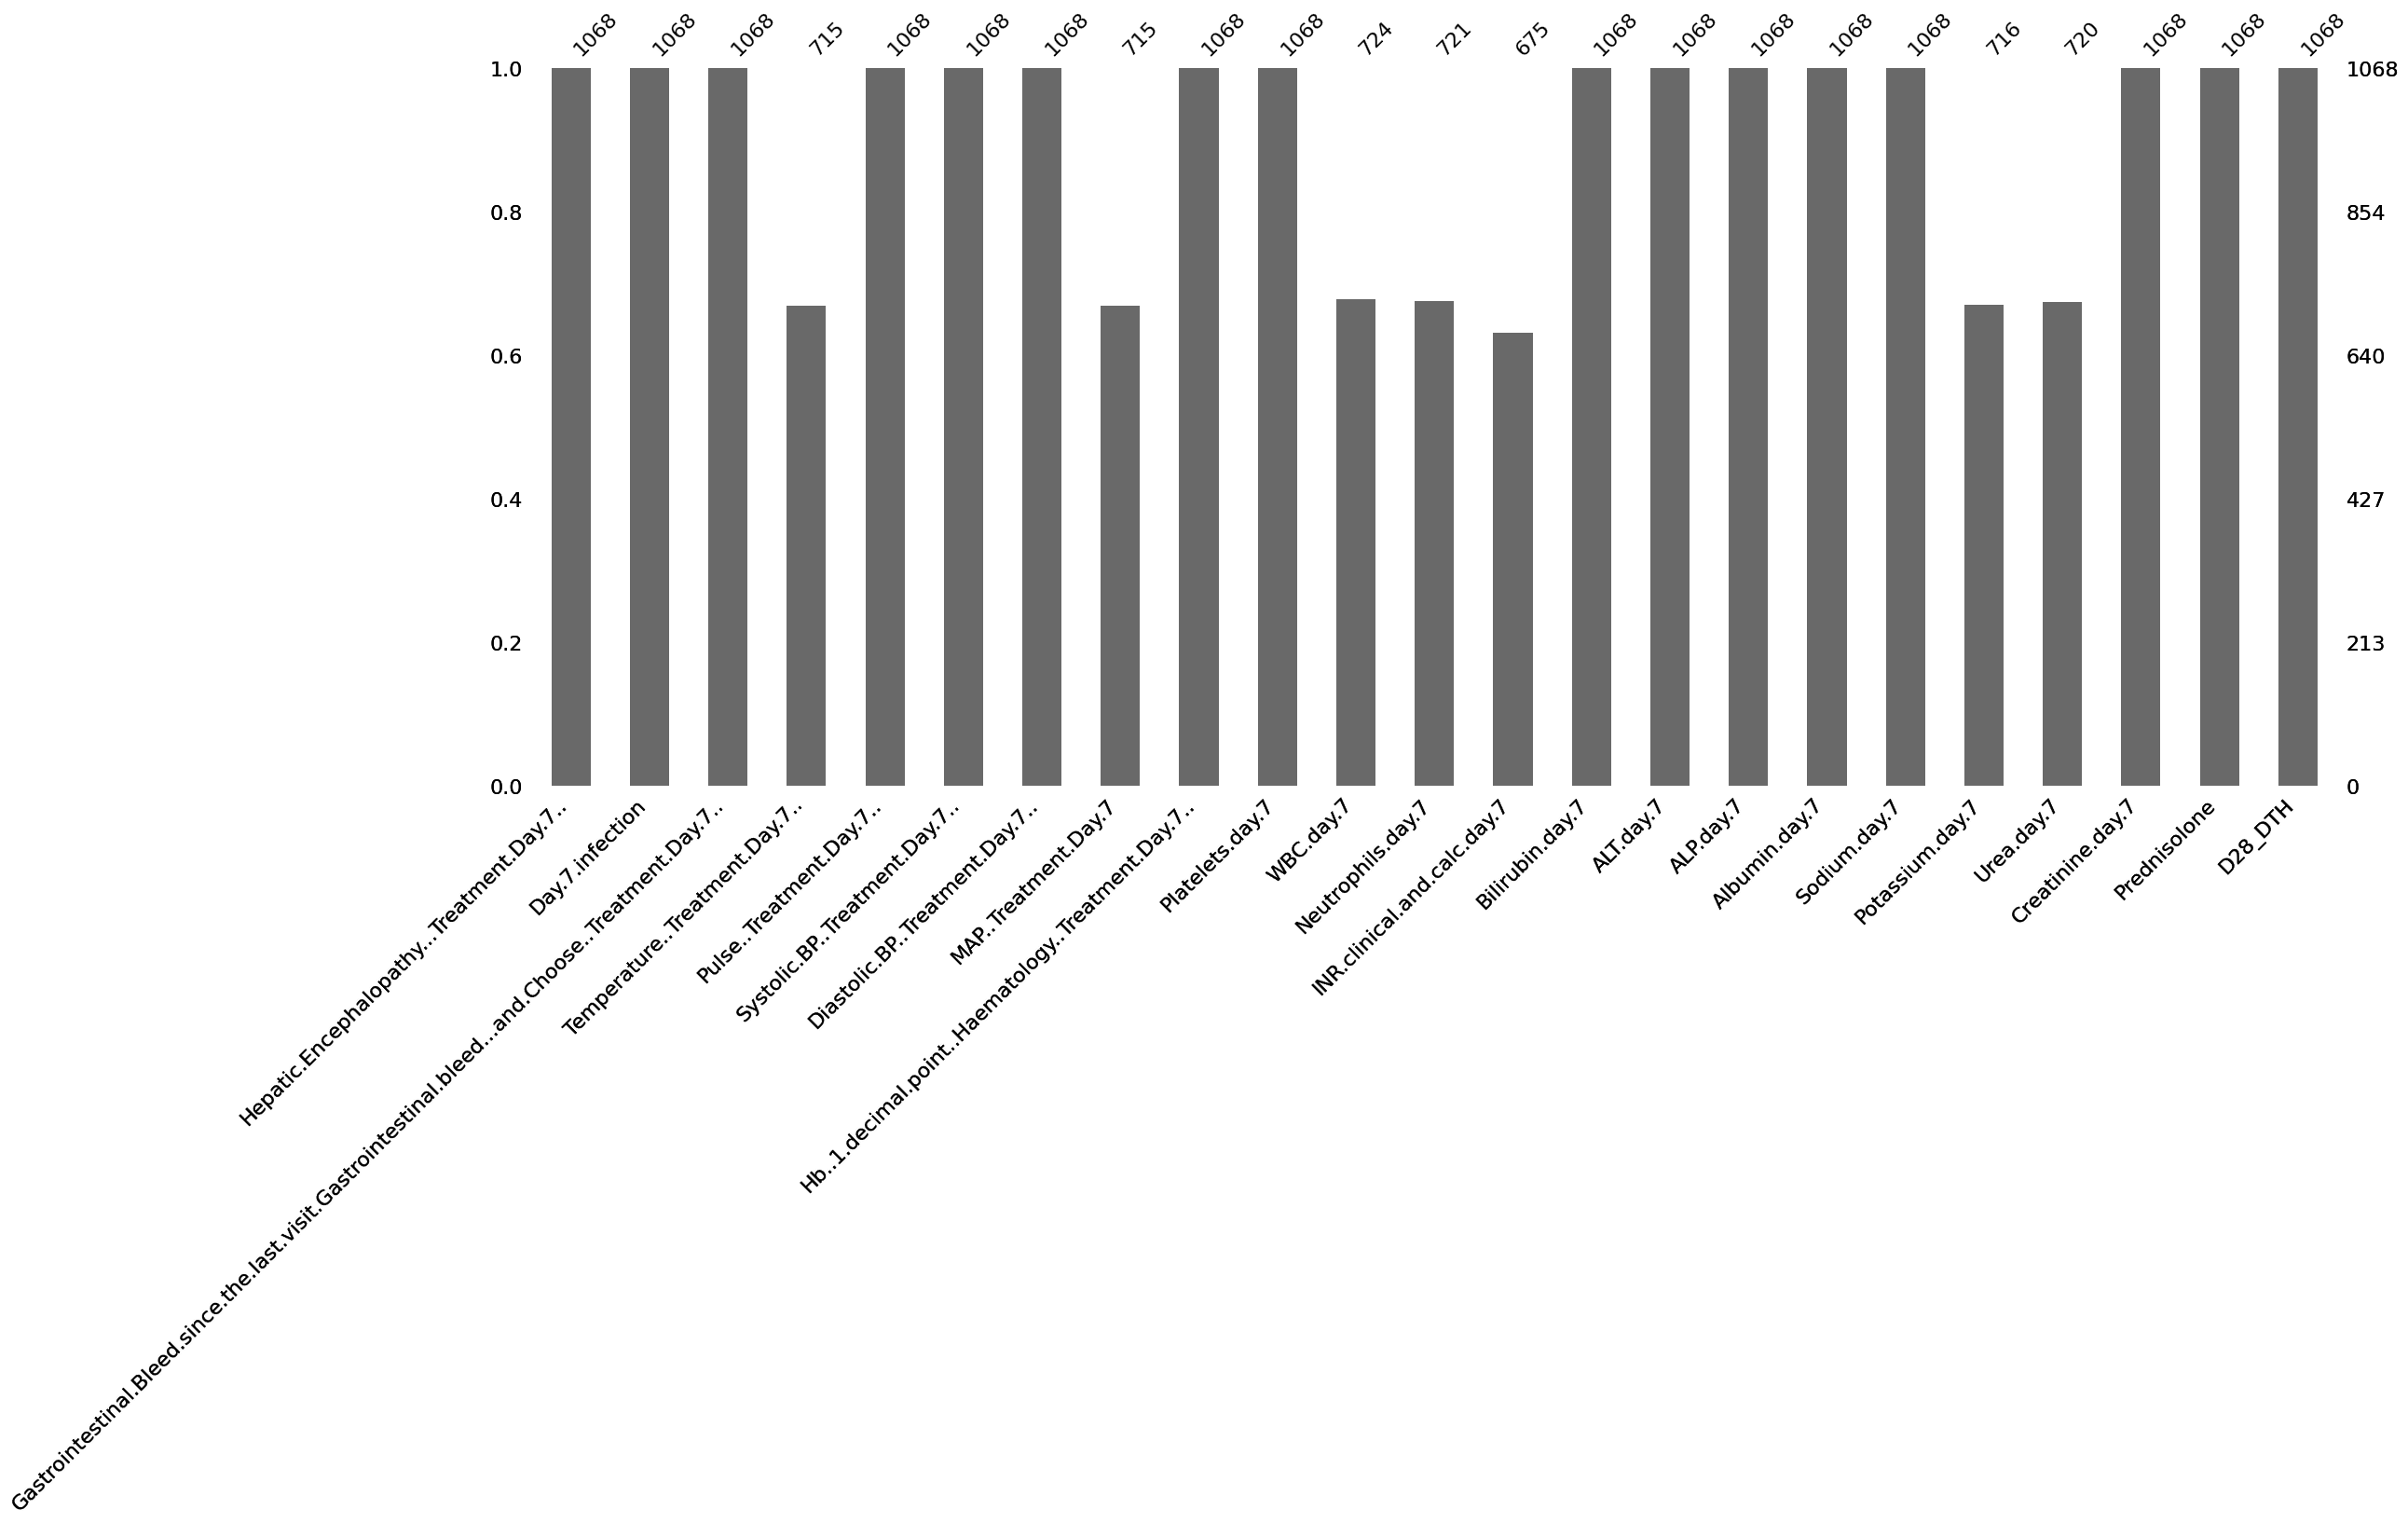

In [4]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [5]:
stopah = stopah.dropna()

In [6]:
df = stopah.loc[stopah['Prednisolone']==1]

In [7]:
df

Hepatic.Encephalopathy...Treatment.Day.7..  Day.7.infection  \
1                                              1                0   
5                                              0                0   
17                                             0                0   
19                                             1                0   
21                                             0                0   
...                                          ...              ...   
1052                                           0                0   
1056                                           0                0   
1060                                           0                1   
1062                                           0                0   
1066                                           0                0   

      Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..  \
1                                                     0                                                    
5                                                     0                                                    
17                                                    0                                                    
19                                                    1                                                    
21                                                    0                                                    
...                                                 ...                                                    
1052                                                  0                                                    
1056                                                  0                                                    
1060                                                  0                                                    
1062                                                  0                                                    
1066                                                  0                                                    

      Temperature..Treatment.Day.7..  Pulse..Treatment.Day.7..  \
1                               36.1                        75   
5                               36.3                        78   
17                              36.5                        82   
19                              37.6                        61   
21                              36.8                        72   
...                              ...                       ...   
1052                            37.0                       109   
1056                            36.8                        61   
1060                            37.8                        85   
1062                            36.1                        80   
1066                            36.8                       120   

      Systolic.BP..Treatment.Day.7..  Diastolic.BP..Treatment.Day.7..  \
1                                110                               72   
5                                108                               63   
17                               110                               60   
19                               129                               80   
21                               130                               90   
...                              ...                              ...   
1052                             140                               80   
1056                              98                               45   
1060                             120                               70   
1062                             109                               75   
1066                             134                               75   

      MAP..Treatment.Day.7  \
1                84.666667   
5                78.000000   
17               76.666667   
19               96.333333   
21              103.333333   
...                    ...   


In [8]:
df = df.drop(['Prednisolone'],axis=1)

In [9]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.25 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.25 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

In [10]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [11]:
model = rf.fit(train, Y_train)

In [12]:
pred_prob = rf.predict_proba(test)

auc_score = roc_auc_score(Y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(train) ==Y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(test) ==Y_test)*100)
print('AUC Score:',(auc_score)*100)

Training accuracy:  91.94630872483222
Test accuracy: 86.48648648648648
AUC Score: 74.06250000000001


In [13]:
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(Y_test, pred_prob[:,1], pos_label=1)

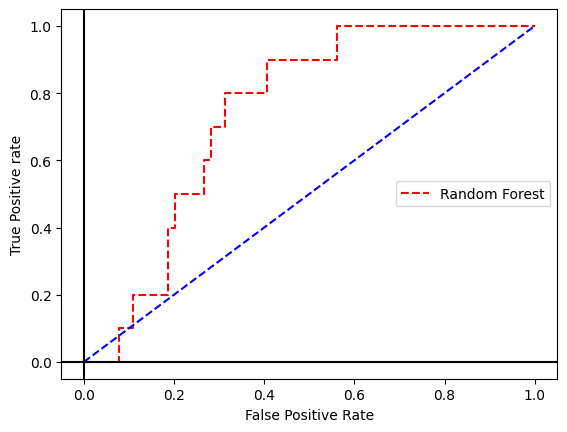

In [14]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();



In [15]:
from sklearn.inspection import permutation_importance

In [16]:
rf.feature_importances_

array([0.10781347, 0.03270325, 0.        , 0.04721062, 0.040645  ,
       0.02979131, 0.04351312, 0.12964733, 0.05313831, 0.0237873 ,
       0.0325482 , 0.0586044 , 0.12337634, 0.09044539, 0.05052814,
       0.05359567, 0.033427  , 0.02317209, 0.02605306])

In [17]:
features = df.columns

In [18]:
features

Index(['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
       'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
       'Temperature..Treatment.Day.7..', 'Pulse..Treatment.Day.7..',
       'Systolic.BP..Treatment.Day.7..', 'Diastolic.BP..Treatment.Day.7..',
       'MAP..Treatment.Day.7',
       'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
       'Platelets.day.7', 'WBC.day.7', 'Neutrophils.day.7',
       'INR.clinical.and.calc.day.7', 'Bilirubin.day.7', 'ALT.day.7',
       'ALP.day.7', 'Albumin.day.7', 'Sodium.day.7', 'Potassium.day.7',
       'Urea.day.7', 'Creatinine.day.7', 'D28_DTH'],
      dtype='object')

Text(0, 0.5, 'variable')

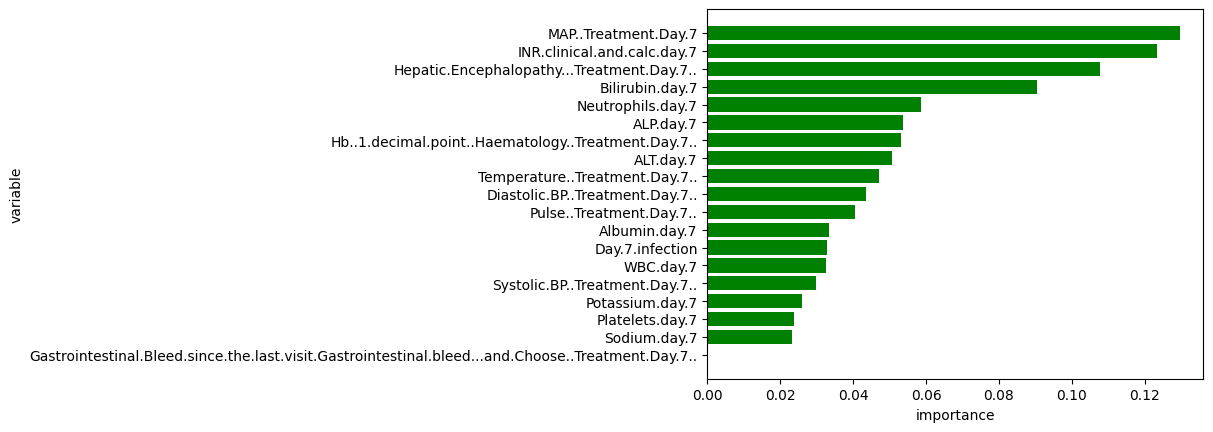

In [20]:
importances = rf.feature_importances_
indices = np.argsort(importances)

values = list(rf.feature_importances_[indices])

#values = [ '%.2f' % elem for elem in values ]

names = [features[i] for i in indices]

importance = pd.DataFrame({'variable' : names, 'importance': values})

importance = importance.sort_values('importance')

plt.axes(facecolor='white')
plt.barh(importance.variable,importance.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [21]:
importance

variable  importance
0   Gastrointestinal.Bleed.since.the.last.visit.Ga...    0.000000
1                                        Sodium.day.7    0.023172
2                                     Platelets.day.7    0.023787
3                                     Potassium.day.7    0.026053
4                      Systolic.BP..Treatment.Day.7..    0.029791
5                                           WBC.day.7    0.032548
6                                     Day.7.infection    0.032703
7                                       Albumin.day.7    0.033427
8                            Pulse..Treatment.Day.7..    0.040645
9                     Diastolic.BP..Treatment.Day.7..    0.043513
10                     Temperature..Treatment.Day.7..    0.047211
11                                          ALT.day.7    0.050528
12  Hb..1.decimal.point..Haematology..Treatment.Da...    0.053138
13                                          ALP.day.7    0.053596
14                                  Neutrophils.day.7    0.058604
15                                    Bilirubin.day.7    0.090445
16         Hepatic.Encephalopathy...Treatment.Day.7..    0.107813
17                        INR.clinical.and.calc.day.7    0.123376
18                               MAP..Treatment.Day.7    0.129647

In [22]:
feature_names = stopah.columns.tolist()[:-1]

In [23]:
feature_names

['Hepatic.Encephalopathy...Treatment.Day.7..',
 'Day.7.infection',
 'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
 'Temperature..Treatment.Day.7..',
 'Pulse..Treatment.Day.7..',
 'Systolic.BP..Treatment.Day.7..',
 'Diastolic.BP..Treatment.Day.7..',
 'MAP..Treatment.Day.7',
 'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
 'Platelets.day.7',
 'WBC.day.7',
 'Neutrophils.day.7',
 'INR.clinical.and.calc.day.7',
 'Bilirubin.day.7',
 'ALT.day.7',
 'ALP.day.7',
 'Albumin.day.7',
 'Sodium.day.7',
 'Potassium.day.7',
 'Urea.day.7',
 'Creatinine.day.7',
 'Prednisolone']

In [24]:
result = permutation_importance(rf, test, Y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean
perm_imp = pd.DataFrame({'variable' : feature_names, 'importance': perm_importances}).sort_values('importance')

round(perm_imp,2)

ValueError: All arrays must be of the same length

In [ ]:
plt.axes(facecolor='white')
plt.barh(perm_imp.variable,perm_imp.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [ ]:
model = rf.fit(train, Y_train)

In [25]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:512])
estimator = sage.KernelEstimator(imputer, 'cross entropy')
sage_train = estimator(train, Y_train, thresh=0.025)
sage_val = estimator(val, Y_val, thresh=0.025)
sage_test = estimator(test, Y_test, thresh=0.025)

100%|██████████| 1/1 [01:54<00:00, 114.71s/it]     


In [32]:
sage.comparison_plot((sage_train, sage_val, sage_test),
                     ('Train', 'Val', 'Test'),
                     feature_names[:4],
                     colors=('tab:orange', 'tab:purple', 'tab:green'),
                     title='Train vs. Val vs. Test')


IndexError: index 12 is out of bounds for axis 0 with size 4